# Current modeling

This notebook adapts the best strategies found in the preliminary notebooks to the extended set of modern hiragana characters. For more details on the datapreprocessing workflow/transfer learning model, please refer to the contents of the [preliminary notebook](initial_findings) directory.

## Imports

In [1]:
#Library imports
import re
import os
import sys
import shutil
import time
import math
import fnmatch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight


from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2

# Allows access to scripts and modules relative to the parent directory.
parent = os.getcwd()
sys.path.append(os.path.join(parent, "functions"))

#User Created functions

from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/functions/setup_functions.py:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

Since there are many classes, I've imported a json that contains useful information about the characters and stored it into a DataFrame.

In [5]:
hiragana_classes = pd.read_json("choubenkyo_kivy_app/app/draw_screen/characters/hiragana.json")

# By converting the recorded stroke count to a list of integers, it will be easier to iterate through the data and remove obvious mistakes from the start.
hiragana_classes["stroke_count"] = hiragana_classes["stroke_count"].map(lambda x: [int(item[0]) for item in re.finditer("\d+", x)])

# It will be useful to have seperate dataframes to account for dropped classes whether they are the obsolete kana or the compound characters.
current_hiragana_classes = hiragana_classes[(hiragana_classes["char_id"]!= "wi") & (hiragana_classes["char_id"]!= "we")].reset_index(drop=True)
reduced_hiragana_classes = current_hiragana_classes.iloc[0:46]
compound_hiragana_classes = current_hiragana_classes.iloc[46:]

## The Data Preprocessing Workflow

In order to minimize computation time, the following code simultaneously constructs the saved images for the CNN and the converted observations for the LSTM

In [6]:
# Stroring the common paths in variables
raw_path = "data/choubenkyo_data/raw"
rendered_path = "data/choubenkyo_data/rasterized"
rendered_split_paths = {"train": os.path.join(rendered_path, "train"),
                        "val": os.path.join(rendered_path, "val"),
                        "test": os.path.join(rendered_path, "test")}

In [7]:
# Reproducible results
np.random.seed(SEED)

# This will control the last dimension of the LSTM layer.
max_strokes=40
max_features = max_strokes * 4

#There are several variations of classes to test on so storing the variable here will make it easier to switch between them.
class_list = current_hiragana_classes

#Creating the inital train, val, test directories. Function located in "cleaning_functions."
create_classification_dirs(rendered_split_paths.values(), class_list["char_id"])

# This is the list which will become the lstm input and labels
choubenkyo_data = []
choubenkyo_raw_labels = []

#This list will reference the directory of origin, and the files that are generated/renamed through the train, test, split
#to external image file functions.
pathmap = []

for source in os.listdir(raw_path):
    old_dir = os.path.join(raw_path, source)
    contents = os.listdir(old_dir)
    for label in class_list["char_id"]:
        matches = fnmatch.filter(contents, f"{label}*")
        np.random.shuffle(matches)
        match_splits = (image_path_list_train_test_split(matches, .7, .1))
        new_file_counters = [len(os.listdir(os.path.join(split_dir, label))) for split_dir in rendered_split_paths.values()]
        for i,(key, value) in enumerate(rendered_split_paths.items()):
            new_dir = os.path.join(value, label)
            for match in match_splits[i]:
                match_raw_path = os.path.join(old_dir, match)
                raw_strokes = load_pickle(match_raw_path)
                smoothed_strokes = parse_to_points_list(raw_strokes)
                if len(raw_strokes) not in hiragana_classes[hiragana_classes["char_id"]==label]["stroke_count"].reset_index(drop=True)[0]:
                    pathmap.append([match_raw_path, np.nan])
                    continue
                new_path = os.path.join(new_dir, f"{label}{key}{new_file_counters[i]:05}.png")
                
                #Exports images for the CNN.
                img = render_coordinates_file_to_img(smoothed_strokes, stroke_width=1)
                img = ImageOps.expand(img, 2)
                img.save(new_path)
                
                #Saves observations for the lstm
                choubenkyo_data.append(strokes_to_array(smoothed_strokes, max_strokes=max_strokes))
                choubenkyo_raw_labels.append(label)
                
                #Saves information to the document that preserves the link to the source images.
                pathmap.append([match_raw_path, new_path])
                
                #Tracks changes to image iterator so some searches for existing directories can be avoided.
                new_file_counters[i] += 1

pathmap = pd.DataFrame(pathmap, columns=["orig_file", "new_file"])
choubenkyo_data = np.vstack(choubenkyo_data)
choubenkyo_raw_labels = pd.Series(choubenkyo_raw_labels)

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/functions/cleaning_functions.py:132: RuntimeWarning: invalid value encountered in true_divide
  angle_group = fill_np_array_nan_neighbors((distance.T / hypot).T, True)


### LSTM Specific Adjustments

The labels are taken care of automatically when Keras's image generator reads from a directory, but the LSTM data will need their labels adjusted to support one-hot encoding.

In [8]:
#Creating a dictionary that will be used to map the character id to an index.
class_list_label_dict = {key:value for key, value in class_list.reset_index()[["char_id","index"]].to_numpy()}

#Mapping to the index so that each label is an integer.
choubenkyo_labels = choubenkyo_raw_labels.map(class_list_label_dict)

It also requires it's own train. test, split. And the following function does that along with standardizing the data.

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_lstm_pipeline(choubenkyo_data, choubenkyo_labels, .2, .1, random_seed=SEED)

Performing a train, test, validation split.


Instead of running an upsample or downsample function, in this instance I handled any possible class imbalances by assigning class weights.

In [10]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(np.argmax(y_train, axis = 1)), 
            y = np.argmax(y_train, axis = 1))

### CNN Specific Adjustments

Since the splits are already in place in the filesystem, the CNN just requires the instantiation of it's generators. The train parameters once gain are a light degree of transformations without reflecting the character.

In [11]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=4,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)

In [14]:
X_train_generator = train_generator.flow_from_directory(rendered_split_paths["train"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_val_generator = test_generator.flow_from_directory(rendered_split_paths["val"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 32)
X_test_generator = test_generator.flow_from_directory(rendered_split_paths["test"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 349)

# I've also created a quick version on the larger training set with no transformations to be tested against the kujishiji model
# wtugut any training.
untransformed_train = test_generator.flow_from_directory(rendered_split_paths["train"], target_size=(32, 32), color_mode='grayscale', seed=SEED, batch_size = 4418)

Found 4418 images belonging to 108 classes.
Found 1345 images belonging to 108 classes.
Found 936 images belonging to 108 classes.
Found 4418 images belonging to 108 classes.


## Modeling

### CNN With Transfer Learning

In [21]:
modelkanji = models.load_model('model_backups/tf_gen_kanji')

In [22]:
layers = modelkanji.layers[:-2] + [Dense(46, "relu"), Dense(108, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
modelc3 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [23]:
for layer in modelc3.layers[0:3]:
    layer.trainable = False

In [24]:
backups = ModelCheckpoint("model_backups/current/modelc3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

resultsc3 = modelc3.fit(X_train_generator, epochs=200, steps_per_epoch=138, validation_data=X_val_generator, validation_steps=42, callbacks=[backups, stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 138 steps, validate for 42 steps
Epoch 1/200
138/138 [==============================] - 3s 22ms/step - loss: 4.6225 - accuracy: 0.0253 - val_loss: 4.3083 - val_accuracy: 0.0595
Epoch 2/200
138/138 [==============================] - 2s 17ms/step - loss: 3.9491 - accuracy: 0.1366 - val_loss: 3.0841 - val_accuracy: 0.3132
Epoch 3/200
138/138 [==============================] - 2s 17ms/step - loss: 2.7654 - accuracy: 0.3488 - val_loss: 1.8616 - val_accuracy: 0.5365
Epoch 4/200
138/138 [==============================] - 2s 17ms/step - loss: 1.8550 - accuracy: 0.5381 - val_loss: 1.1561 - val_accuracy: 0.6845
Epoch 5/200
138/138 [==============================] - 2s 17ms/step - loss: 1.2532 - accuracy: 0.6687 - val_loss: 0.7655 - val_accuracy: 0.7753
Epoch 6/200
138/138 [==============================] - 2s 17ms/step - loss: 0.9073 - accuracy: 0.7405 - val_loss: 0.5197 - val_accuracy: 0.8445
Epoch 7/200
138/138 [======================

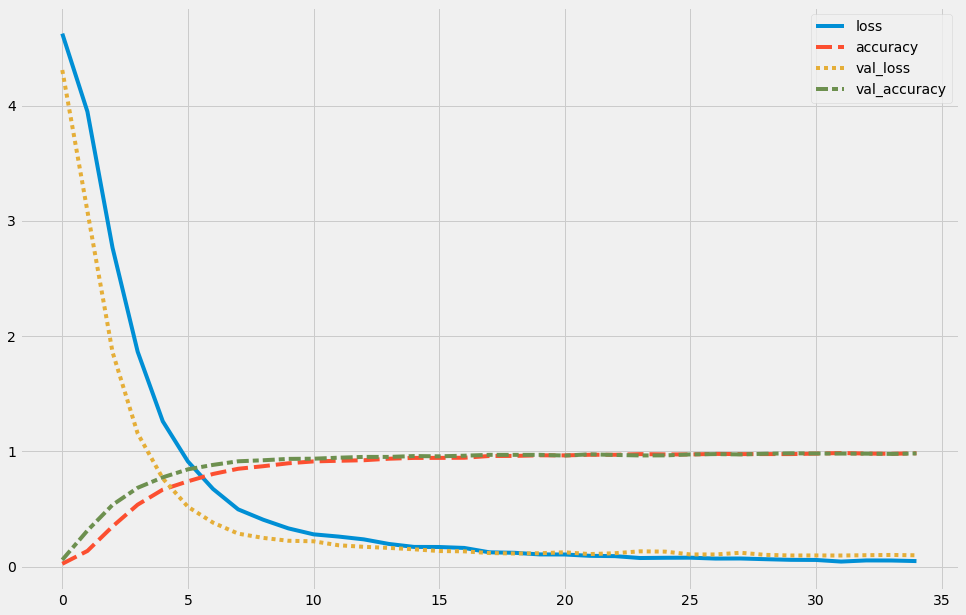

,loss,accuracy,val_loss,val_accuracy
30,0.058591,0.981076,0.097819,0.982143
31,0.044504,0.986092,0.097160,0.981399
32,0.054469,0.981532,0.099837,0.980655
33,0.053857,0.979252,0.101932,0.978423
34,0.048777,0.983812,0.099056,0.982887


In [25]:
plot_keras_fit_history(resultsc3, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [26]:
%%time
test_batch = next(X_test_generator)
image_class_evaluation(modelc3, test_batch[0], test_batch[1])

Accuracy: 0.9627507163323782
Balanced Accuracy: 0.9685096153846153
CPU times: user 126 ms, sys: 17.7 ms, total: 144 ms
Wall time: 135 ms


(0.9627507163323782, 0.9685096153846153)

### The LSTM

Using an LSTM on the coordinate data holds a lot of promise in being the model of choice because of several factors.
* It makes of the captured stroke order and stroke directions that are lost in the bitmap conversion.
* The recorded points offer much more precision that what is available when the images are rendered to a 32 x 32 pixel grid.

Both of these will grow more important with increases in the complexity of the character sets.

In [27]:
layers = [LSTM(400, input_shape=(120,max_features)),
          Dropout(0.1),
          Dense(46, activation='relu'),
          Dense(108, activation='softmax'),
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00003), "metrics":['accuracy']}
modelc4 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 400)               897600    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 46)                18446     
_________________________________________________________________
dense_7 (Dense)              (None, 108)               5076      
Total params: 921,122
Trainable params: 921,122
Non-trainable params: 0
_________________________________________________________________


In [28]:
backups = ModelCheckpoint("model_backups/current/modelc4-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=8, restore_best_weights=True)

resultsc4 = modelc4.fit(X_train, y_train, epochs=200, batch_size=10, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[backups, stopping])

Train on 4823 samples, validate on 536 samples
Epoch 1/200
4823/4823 [==============================] - 8s 2ms/sample - loss: 4.6559 - accuracy: 0.0145 - val_loss: 4.5649 - val_accuracy: 0.0448
Epoch 2/200
4823/4823 [==============================] - 7s 1ms/sample - loss: 4.3289 - accuracy: 0.0634 - val_loss: 4.0679 - val_accuracy: 0.1138
Epoch 3/200
4823/4823 [==============================] - 7s 1ms/sample - loss: 3.7323 - accuracy: 0.1528 - val_loss: 3.3709 - val_accuracy: 0.2481
Epoch 4/200
4823/4823 [==============================] - 7s 1ms/sample - loss: 3.0798 - accuracy: 0.3085 - val_loss: 3.3397 - val_accuracy: 0.2201
Epoch 5/200
4823/4823 [==============================] - 7s 1ms/sample - loss: 2.4805 - accuracy: 0.4742 - val_loss: 2.1287 - val_accuracy: 0.5914
Epoch 6/200
4823/4823 [==============================] - 7s 1ms/sample - loss: 2.0431 - accuracy: 0.5930 - val_loss: 1.8905 - val_accuracy: 0.6119
Epoch 7/200
4823/4823 [==============================] - 7s 1ms/sample 

Graphing the results of the LSTM over the epochs reveals much more volitility. I would like to add on more observations before refining further.

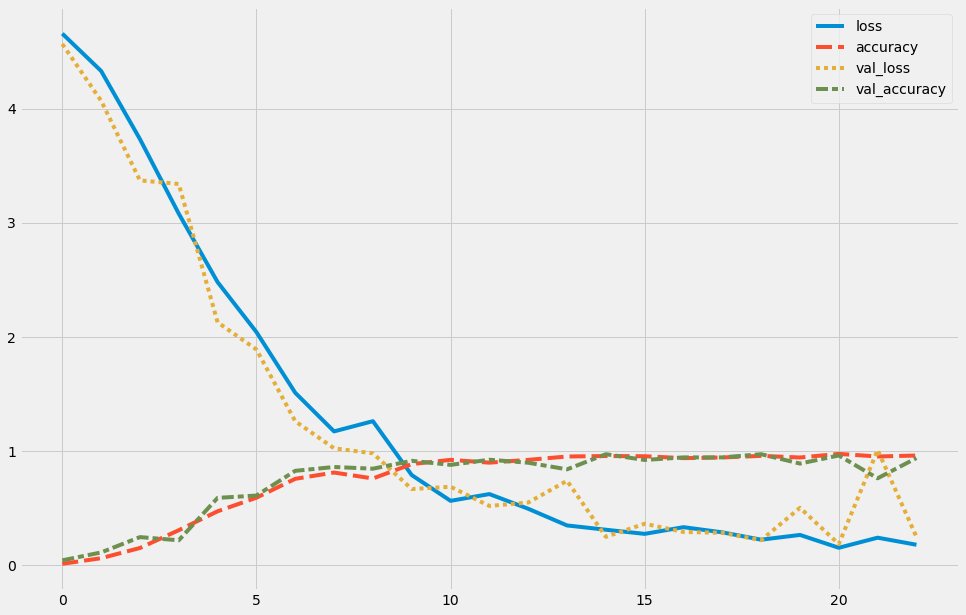

,loss,accuracy,val_loss,val_accuracy
18,0.225459,0.959154,0.221288,0.973881
19,0.267184,0.945055,0.504588,0.891791
20,0.154685,0.976571,0.187264,0.962687
21,0.243075,0.953971,1.010715,0.763060
22,0.181175,0.962264,0.249637,0.940298


In [29]:
plot_keras_fit_history(resultsc4, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [30]:
%%time
image_class_evaluation(modelc4, X_test, y_test)

Accuracy: 0.9783582089552239
Balanced Accuracy: 0.9800659617857329
CPU times: user 669 ms, sys: 223 ms, total: 892 ms
Wall time: 469 ms


(0.9783582089552239, 0.9800659617857329)